In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tensorboardX import SummaryWriter

plt.ion()   # interactive mode
%matplotlib inline

Load Data
---------


In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images


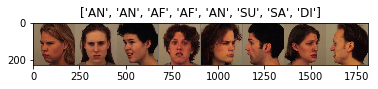

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [4]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, writer=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            

            writer.add_scalar(phase+"/loss", epoch_loss, epoch)
            writer.add_scalar(phase+"/acc", epoch_acc, epoch)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [6]:
model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)

writer = SummaryWriter('./logs/resnet152_full_low_lr')

### Train and evaluate



In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer,
                       num_epochs=35)

Epoch 0/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:18<00:00,  2.92it/s]


train Loss: 1.1543 Acc: 0.5754


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.10it/s]


val Loss: 0.5406 Acc: 0.7976

Epoch 1/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:22<00:00,  2.87it/s]


train Loss: 0.4703 Acc: 0.8379


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.12it/s]


val Loss: 0.3663 Acc: 0.8785

Epoch 2/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:24<00:00,  2.84it/s]


train Loss: 0.3182 Acc: 0.8938


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  6.27it/s]


val Loss: 0.2342 Acc: 0.9271

Epoch 3/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:26<00:00,  2.82it/s]


train Loss: 0.2150 Acc: 0.9336


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.08it/s]


val Loss: 0.1931 Acc: 0.9312

Epoch 4/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:26<00:00,  2.82it/s]


train Loss: 0.1443 Acc: 0.9531


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.11it/s]


val Loss: 0.1668 Acc: 0.9433

Epoch 5/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:26<00:00,  2.82it/s]


train Loss: 0.1376 Acc: 0.9544


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.13it/s]


val Loss: 0.1716 Acc: 0.9474

Epoch 6/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:24<00:00,  2.84it/s]


train Loss: 0.0750 Acc: 0.9798


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  6.21it/s]


val Loss: 0.1552 Acc: 0.9595

Epoch 7/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:22<00:00,  2.88it/s]


train Loss: 0.0588 Acc: 0.9849


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  6.25it/s]


val Loss: 0.1430 Acc: 0.9636

Epoch 8/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:21<00:00,  2.88it/s]


train Loss: 0.0530 Acc: 0.9865


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  6.21it/s]


val Loss: 0.1402 Acc: 0.9595

Epoch 9/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:22<00:00,  2.88it/s]


train Loss: 0.0481 Acc: 0.9888


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.17it/s]


val Loss: 0.1372 Acc: 0.9636

Epoch 10/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:23<00:00,  2.86it/s]


train Loss: 0.0392 Acc: 0.9914


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.89it/s]


val Loss: 0.1482 Acc: 0.9595

Epoch 11/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:23<00:00,  2.87it/s]


train Loss: 0.0360 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.99it/s]


val Loss: 0.1285 Acc: 0.9595

Epoch 12/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:23<00:00,  2.86it/s]


train Loss: 0.0336 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.17it/s]


val Loss: 0.1363 Acc: 0.9676

Epoch 13/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:24<00:00,  2.85it/s]


train Loss: 0.0294 Acc: 0.9942


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.76it/s]


val Loss: 0.1115 Acc: 0.9676

Epoch 14/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:25<00:00,  2.83it/s]


train Loss: 0.0345 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.01it/s]


val Loss: 0.1122 Acc: 0.9595

Epoch 15/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:23<00:00,  2.85it/s]


train Loss: 0.0342 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.11it/s]


val Loss: 0.1234 Acc: 0.9676

Epoch 16/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:25<00:00,  2.84it/s]


train Loss: 0.0340 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.03it/s]


val Loss: 0.1341 Acc: 0.9676

Epoch 17/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:25<00:00,  2.83it/s]


train Loss: 0.0349 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.13it/s]


val Loss: 0.1245 Acc: 0.9676

Epoch 18/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:23<00:00,  2.86it/s]


train Loss: 0.0313 Acc: 0.9935


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.18it/s]


val Loss: 0.1194 Acc: 0.9636

Epoch 19/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:24<00:00,  2.84it/s]


train Loss: 0.0320 Acc: 0.9933


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.13it/s]


val Loss: 0.1203 Acc: 0.9676

Epoch 20/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:24<00:00,  2.85it/s]


train Loss: 0.0293 Acc: 0.9938


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.06it/s]


val Loss: 0.1188 Acc: 0.9595

Epoch 21/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:22<00:00,  2.87it/s]


train Loss: 0.0284 Acc: 0.9940


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.16it/s]


val Loss: 0.1331 Acc: 0.9636

Epoch 22/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:22<00:00,  2.88it/s]


train Loss: 0.0279 Acc: 0.9942


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.05it/s]


val Loss: 0.1138 Acc: 0.9676

Epoch 23/34
----------


 69%|███████████████████████████████████████████████████████▎                        | 402/582 [02:20<01:03,  2.85it/s]

ConvNet as fixed feature extractor
----------------------------------




In [ ]:
model_conv = torchvision.models.resnet152(pretrained=True)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(list(model_conv.fc.parameters())+list(model_conv.layer4.parameters())+list(model_conv.layer3.parameters())+list(model_conv.layer2.parameters()), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=6, gamma=0.1)

writer = SummaryWriter('./logs/resnet152_last4layers')

### Train and evaluate

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, writer, num_epochs=40)